# Lab2 Intro
- **Text embedding** is a foundational technique in natural language processing (NLP) that transforms words and phrases into numerical representations, allowing machines to understand and process human language effectively. This process involves converting text into dense vectors, which are arrays of numbers that capture the semantic meaning and relationships between words.
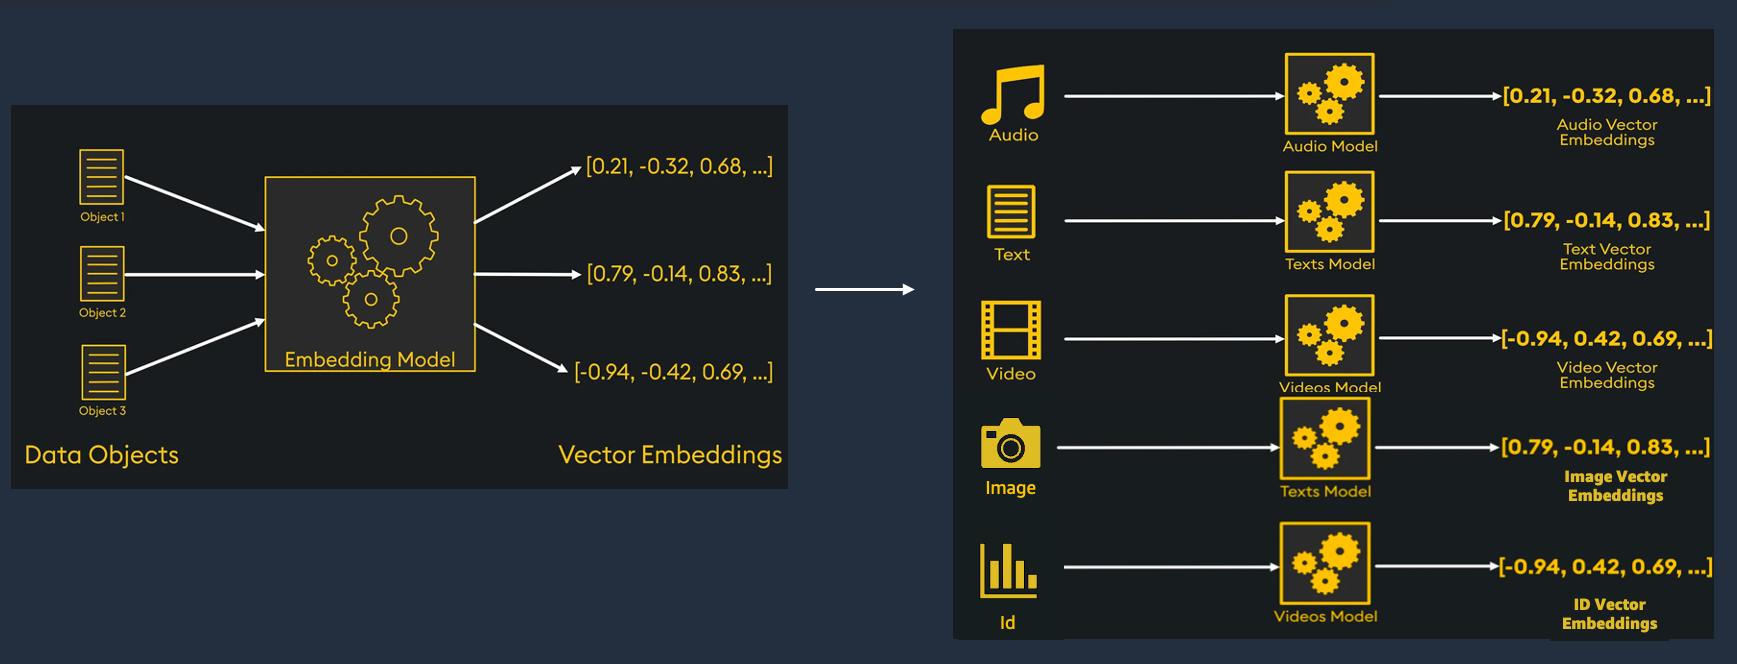

- Embeddings capture the meaning of words in context, which is essential for retrieving results that are semantically similar, even if they do not share exact keywords.

- Methods for Calculating Similarity between embedding vectors:
    - ***Cosine Similarity*** - [Cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) measures the cosine of the angle between two vectors in a multi-dimensional space. 
    - ***Euclidean Distance*** - [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) measures the "straight line" distance between two points (or vectors) in space. 

### Using Embedding Techniques to Classify VoC
In Lab1, you applied Prompt Engineering to construct the classification task. In this section, you will delve into text embedding techniques, gaining hands-on experience in their utilization. This exploration will enhance your understanding of how embeddings can capture semantic relationships within text. You'll learn to implement these techniques step-by-step, and perform the classification task.

### Your objectives are:
- Create embeddings for 35+ categories labels
- Create embeddings for each comment
- Compare the similarity between label embedding vectors and comment embedding vectors to find the most appropriate category label

## 1. Install dependencies
- If you experince "ERROR: pip's dependency resolver does not currently...", please just ignore it

In [ ]:
!pip install -q langchain==0.2.16 langchain_aws==0.1.17 pandas==2.2.2 openpyxl==3.1.5 termcolor==2.4.0

## 2. Initialize Bedrock model using Langchain
- First let's see what Amazon embedding models we have in Amazon Bedrock

In [ ]:
import boto3
import json
import copy
import pandas as pd
from termcolor import colored
# create clients of bedrock
bedrock = boto3.client(service_name='bedrock')
bedrock_runtime = boto3.client(service_name='bedrock-runtime') 
pd.set_option('display.max_rows', None)
results = []

available_models = bedrock.list_foundation_models()
for model in available_models['modelSummaries']:
    if 'Amazon' in model['providerName'] and 'EMBEDDING' in model['outputModalities']: 
        results.append({
            'Model Name': model['modelName'],
            'Model ID': model['modelId'],  # Add Model ID column
            'Provider': model['providerName'],
            'Input Modalities': ', '.join(model['inputModalities']),
            'Output Modalities': ', '.join(model['outputModalities']),
            'Streaming': model.get('responseStreamingSupported', 'N/A'),
            'Status': model['modelLifecycle']['status']
        })

df = pd.DataFrame(results)
display(df)

pd.reset_option('display.max_rows')

We utilize [Langchain](https://www.langchain.com/) SDK to initialize a BedrockEmbeddings object with 'Titan Text Embeddings V2' identified by the model ID "amazon.titan-embed-text-v2:0". We will use this BedrockEmbeddings object later to generate text embeddings for both the categories and the comments.

In [ ]:
from langchain_aws.embeddings.bedrock import BedrockEmbeddings
bedrock_embedding = BedrockEmbeddings(model_id='amazon.titan-embed-text-v2:0')

- test run and preview the result

Let's start with a test run to explore the capabilities of the embedding object. We'll see how the sentence "I love programming" is effectively transformed into dense vectors with 1024 dimensions.

In [ ]:
test_embedding = bedrock_embedding.embed_documents(['I love programing'])
print(f"The embedding dimension is {len(test_embedding[0])}, first 10 elements are: {test_embedding[0][:10]}")

## 3. Preparing the Dataset to be classified. 
- The data (Voice of Customers) is subject to experiment usage only

Below, we load the categories.csv and comments.csv data file. These are the same dataset we used in Lab1.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
category_definition = "data/categories.csv"
categories = pd.read_csv(category_definition)
display(categories)

### Load the customer review data

In [ ]:
comments_filepath = "data/comments.csv"
comments = pd.read_csv(comments_filepath)
comments[:3]

## 4. Generate embeddings for category explaination text and customer review text
Let's dive into hands-on experience with text embedding. By following the steps below, we will convert the categories and comments from the dataset into numerical representations ( high-dimensional vectors). This process will enable us to capture the semantic essence of the text. We'll explore how these embeddings can be utilized in classification.

### 4.1 Create embeddings for categories 

In [ ]:
category_embeddings = bedrock_embedding.embed_documents(categories['mappings'].values)

In [ ]:
print(f'Rows of category_embeddings:{len(category_embeddings)}')

### 4.1 Create embeddings for customer review comments 

In [ ]:
comments_embeddings = bedrock_embedding.embed_documents(comments['comment'].values)

In [ ]:
print(f'Rows of comments_embeddings:{len(comments_embeddings)}')

### 4.2 Calculate the similarity
With the embedded vectors in hand, we can now calculate the similarity between comments and categories. We will use the cosine similarity method, which we introduced earlier, to measure the dimensional distance between comments and categories. The comment whose vector is most similar to a category's vector will be classified under that category.

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_embeddings_batch(query_matrix, embedding_matrix, top_k=2):
    """
    Find the top k similar embeddings in the embedding matrix for multiple query vectors.
    
    :param query_matrix: Matrix of query embedding vectors (2D numpy array)
    :param embedding_matrix: Matrix of embeddings to search in (2D numpy array)
    :param top_k: Number of top similar embeddings to return for each query
    :return: Indices of top k similar embeddings and their similarity scores for each query
    """
    # Calculate cosine similarity for all queries at once
    similarities = cosine_similarity(query_matrix, embedding_matrix)
    
    # Get the indices of top k similar embeddings for each query
    top_indices = np.argsort(similarities, axis=1)[:, ::-1][:, :top_k]
    
    # Get the similarity scores for top k for each query
    top_scores = np.take_along_axis(similarities, top_indices, axis=1)
    
    return top_indices, top_scores

- Using comments_embeddings as query matrix, to query the most similar vector in category_embeddings matrix

In [ ]:
top_indices, top_scores = find_similar_embeddings_batch(query_matrix=comments_embeddings,
                                                        embedding_matrix=category_embeddings,
                                                       top_k=1)

- Use the top indice to locate the category label
- convert to pandas dataframe

In [ ]:
predicts = [ categories.loc[i]['mappings'].values[0] for i in top_indices]
predict_labels = pd.DataFrame(predicts,columns=['predict_label'])
predict_labels

 ### 4.3 Concate prediction result to the Groundtruth and calculate the accuracy
 To assess the accuracy of the classification, we'll concatenate the predicted categories with the actual categories (Groundtruth) from our dataset. Once merged, we can calculate the accuracy by determining the percentage of comments for which the predicted category matches the Groundtruth. 

- copy comments to ground_truth dataframe

In [ ]:
ground_truth = comments.copy()
ground_truth

In [ ]:
merge_df=pd.concat([ground_truth,predict_labels],axis=1)
merge_df

## 5.Calculate the accuracy

In [ ]:
accuracy = (merge_df['groundtruth'] == merge_df['predict_label']).mean()

In [ ]:
print(colored(f"****accuracy:****\n{accuracy}","green"))

### Save the result 

In [ ]:
merge_df.to_csv('result_lab_2.csv',index=False)